# 0) Set up


### import and install libraries

In [1]:
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
!pip install efficientnet_pytorch 

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-nwqv7g9c
  Running command git clone -q https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-nwqv7g9c
  Created wheel for warmup-scheduler: filename=warmup_scheduler-0.3.2-py3-none-any.whl size=3878 sha256=d12b2647ceebaaed448835bd44d876ae3e12bd48baa803a5c1b036a047c8f852
  Stored in directory: /tmp/pip-ephem-wheel-cache-msnv1ski/wheels/bf/81/52/0e3bc0b645a339f94c76b4dcb8c8b7a5f588a614f5add83b9f
Successfully built warmup-scheduler
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=adff2536b1b73d3a29de34fc8ff76ce0894a62c2bfcf505c5d1becff1bdbede0
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [2]:
import sys
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
import albumentations
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.optim import Adam,SGD
import pickle
import torchvision.models as models
from efficientnet_pytorch import model as enet
import efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
import logging


### connect to Google Drive and create dataframes

In [3]:
### connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
BASE_PATH = '/content/drive/MyDrive/mvadlmi'

# data directory
data_dir = f'{BASE_PATH}'

# create dataframe of training and test labels as well as anotations.
train_df = pd.read_csv(f'{data_dir}/train/train/train.csv')
test_df = pd.read_csv(f'{BASE_PATH}/test/test/test.csv')

In [5]:
#remove labels that don't have a mask
taboo = ['f12da90682826a7b149fc550722e14c4','3ae66332c2dd50c6ce458937d49f8232']
train_df = train_df[~train_df['image_id'].isin(taboo)]

In [6]:
# import training tiles
import pickle
file = open('/content/drive/MyDrive/map_id_tiles_train_ski_image.pkl', "rb")
tiles_train = pickle.load(file)
file.close()


In [7]:
# import test tiles
file = open('/content/drive/MyDrive/map_id_tiles_test.pkl', "rb")
tiles_test = pickle.load(file)
file.close()

In [8]:
file = open('/content/drive/MyDrive/tiles_test_withmasks.pkl', "rb")
tiles_test_masks = pickle.load(file)
file.close()

# 1) Dataloader and model

### create a dataloader function that returns tiles + labels if in train mode, and the tiles + image name if in test mode

In [9]:
class Classifier_data(Dataset):
    def __init__(self, anotation , tiles, mode='train'):
        self.anotation = anotation
        self.mode = mode
        self.tiles = tiles
        
    def __len__(self):
        return len(self.anotation)
    
    def __getitem__(self, idx):
        
        if self.mode == 'test':
            img_id  = self.anotation.loc[idx,['image_id']].values[0]
        else:
            img_id, label_isup = self.anotation.loc[idx,['image_id','isup_grade']].values
        tiles_im = self.tiles[img_id]

        if self.mode == 'train' or self.mode == 'valid':
            return tiles_im, torch.tensor(label_isup)
        else:
            return tiles_im, img_id

### Override the collate_fn function in order to process the tiles. This way the pre-processing is done in a well identified function.

In [10]:
def default_collate_ml(batch):
    
    x_train = []
    y_train = []
    
    for i in range(len(batch)):
        
        x_train.extend([torch.FloatTensor(tile['image']).permute(2,1,0) for tile in batch[i][0]])
        y_train.append(batch[i][1])
        
    data = torch.stack(x_train, dim=0)
    shape = data.shape
    
        #concatenate the output for tiles into a single map
    data = data.view(-1,36,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous()\
          .view(-1,shape[1],shape[2]*36,shape[3])
    
    if type(batch[0][1])==str :
        return data, y_train
    
    y_train = torch.stack(y_train)
    return data, y_train

def default_collate_masks(batch):
    
    x_train = []
    y_train = []
    
    for i in range(len(batch)):
        x_train.extend([torch.cat((torch.FloatTensor(tile['image']).permute(2,1,0),torch.unsqueeze(torch.FloatTensor(tile['mask'][:,:,0]),0)),0) for tile in batch[i][0][:24]])
        y_train.append(batch[i][1])
        
    data = torch.stack(x_train, dim=0)
    shape = data.shape
    
        #concatenate the output for tiles into a single map
    data = data.view(-1,12,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous()\
          .view(-1,shape[1],shape[2]*24,shape[3])
    
    if type(batch[0][1])==str :
        return data, y_train
    
    y_train = torch.stack(y_train)
    return data, y_train


def default_collate_masks_test(batch):
    
    x_train = []
    y_train = []
    
    for i in range(len(batch)):
        x_train.extend([torch.cat((torch.FloatTensor(tile['image']).permute(2,1,0),torch.unsqueeze(torch.FloatTensor(tile['mask']),0)),0) for tile in batch[i][0][:12]])
        y_train.append(batch[i][1])
        
    data = torch.stack(x_train, dim=0)
    shape = data.shape
    
        #concatenate the output for tiles into a single map
    data = data.view(-1,12,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous()\
          .view(-1,shape[1],shape[2]*12,shape[3])
    
    if type(batch[0][1])==str :
        return data, y_train
    
    y_train = torch.stack(y_train)
    return data, y_train

### create datasets and dataloaders

In [11]:
train, valid = train_test_split(train_df,test_size=0.2,stratify= train_df['isup_grade'])
batch_size = 2

train_dataset = Classifier_data(train.reset_index(drop=False),tiles_train)
valid_dataset = Classifier_data(valid.reset_index(drop=False),tiles_train)
train_loader = DataLoader(dataset=train_dataset, collate_fn = default_collate_ml, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, collate_fn = default_collate_ml, batch_size=batch_size, shuffle=False)

### Data augmentation

In [12]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])
transforms_val = albumentations.Compose([])

### create the model

In [13]:
def create_model(modeltype='resnet18', pretrained = True, GPU = True):
    if  modeltype == 'resnet18' :
        if pretrained == True :
            model = models.resnet18(pretrained=True)
            for param in model.parameters():
              param.requires_grad = False
        else : 
            model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(512, 6) 

    elif modeltype =='alexnet' :
        if pretrained == True :
            model = models.alexnet(pretrained=True)
            for param in model.parameters():
              param.requires_grad = False
        else : 
            model = models.alexnet(pretrained=False)
        model.classifier[-1]=nn.Linear(4096,6, bias=True)

    elif modeltype =='vgg16' :
        if pretrained == True :
            model = models.vgg16(pretrained=True)
            for param in model.parameters():
              param.requires_grad = False
        else : 
            model = models.vgg16(pretrained=False)
        model.classifier[-1]=nn.Linear(4096,6, bias=True)
      
    elif modeltype == 'resnext' :
        if pretrained == True :
            model = models.resnext50_32x4d(pretrained=True)
            for param in model.parameters():
                param.requires_grad = False
        else : 
            model = models.resnext50_32x4d(pretrained=False)
        model.fc=nn.Linear(2048,6, bias=True)
    elif (modeltype == 'efficientnet'):
        if pretrained == True :
            """model = EfficientNet.from_pretrained('efficientnet-b0')
            model._fc = nn.Linear(model._fc.in_features, 6)"""
            model_path = '/content/drive/MyDrive/efficientnet-b0-08094119.pth'
            model = enet.EfficientNet.from_name('efficientnet-b0')
            model.load_state_dict(torch.load(model_path))
            model._fc = nn.Linear(model._fc.in_features, 6)
            model = model.to(device)
            model = torch.nn.DataParallel(model)
        else : 
            model = models.efficientnet_b0(pretrained=False)
            model.classifier=nn.Linear(1280,6, bias=True)
    else :
        raise ValueError("model needs to be in the list : ",['resnet18','alexnet','vgg16','resnext','efficientnet'])

    if GPU :
        model = model.to(device)
        model = torch.nn.DataParallel(model)
    return model


# 2) Train the model

### create training function

In [14]:
def train_model(model,optimizer,criterion,epochs):
    warmup_epo = 1

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
    scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)
    
    tlen = len(train_dataset)
    tlen_valid = len(valid_dataset)
    accumulation_steps = 2
    valid_pred = np.zeros((len(valid_dataset),6))
    train_pred = np.zeros((len(train_dataset),6))
    train_target = np.zeros((len(train_dataset)))
    acc_max = 0.
    acc_train_list = []
    acc_valid_list = []
    acc_list = []
    for epoch in range(epochs):
        batch_i = 0
        tloss = 0
        tloss_valid = 0
        acc = np.zeros(1)
        acc_valid = np.zeros(1)
        
        model.train()
        optimizer.zero_grad()
        for i,(x_train, y_train) in enumerate(train_loader): 
            
            
            outputs = model(x_train.cuda())
            torch.cuda.empty_cache() 
            
            loss = criterion(outputs,  y_train.long().cuda())
            loss.backward()
            if (batch_i+1) % accumulation_steps == 0:            
                optimizer.step()   
                scheduler.step()                        
                optimizer.zero_grad()
            
            tloss += loss.item()
            batch_i+=1
            
            train_pred[i * batch_size:(i+1) * batch_size] = outputs.detach().cpu().numpy()
            train_target[i * batch_size:(i+1) * batch_size] = y_train.detach().cpu().numpy()
            

            del loss, outputs, y_train, x_train

        #Valid acc
        model.eval()
        with torch.no_grad():
            for i,(x_train, y_train) in enumerate(valid_loader):
                
                outputs = model(x_train.cuda())
                torch.cuda.empty_cache() 

                loss = criterion(outputs,  y_train.long().cuda())
                tloss_valid += loss.item()
                
                valid_pred[i * batch_size:(i+1) * batch_size] = outputs.detach().cpu().numpy()
                del loss, outputs, y_train, x_train
            
        acc = 100*cohen_kappa_score(train_pred.argmax(axis =1),train_target,weights='quadratic')
        acc_k = 100*cohen_kappa_score((train_pred[train['data_provider'] == 'karolinska']).argmax(axis=1), train_target[train['data_provider'] == 'karolinska'], weights='quadratic')
        acc_r = 100*cohen_kappa_score((train_pred[train['data_provider'] == 'radboud']).argmax(axis=1), train_target[train['data_provider'] == 'radboud'], weights='quadratic')
        acc_train_list.append([acc,acc_k, acc_r])
        

        acc_valid = 100*cohen_kappa_score(valid_pred.argmax(axis =1),valid['isup_grade'],weights='quadratic')
        acc_valid_k = 100*cohen_kappa_score((valid_pred[valid['data_provider'] == 'karolinska']).argmax(axis=1), valid[valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
        acc_valid_r = 100*cohen_kappa_score((valid_pred[valid['data_provider'] == 'radboud']).argmax(axis=1), valid[valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
        
        acc_valid_list.append([acc_valid,acc_valid_k,acc_valid_r])
        acc_list.append(acc_valid)

        if acc_valid > acc_max:
            print('score ({:.6f} --> {:.6f}).  Saving model ...'.format(acc_max, acc_valid))
            torch.save(model.state_dict(), 'best_weights.pth')
            acc_max = acc_valid
        
        print('Epoch {} -> Train Loss: {:.4f}, Valid Loss: {:.4f}, ACC_train: {:.2f}%, ACC_valid: {:.2f}%'.format(epoch+1, tloss/tlen, tloss_valid/tlen_valid, acc, acc_valid))
    return model,acc_train_list, acc_valid_list, acc_list

### Set hyper parameters

In [15]:
#@title
init_lr = 0.0003
n_epochs = 2
warmup_factor = 5
criterion = nn.CrossEntropyLoss()

### create plot functions

In [15]:
#@title
def plot_accuracies_all(acc_train_list,acc_valid_list, title):
    y1=[]
    y2=[]
    y3=[]
    y4=[]
    y5=[]
    y6=[]
    epochs = len(acc_train_list)
    x=np.arange(1,epochs+1)
    for each in acc_train_list :
        y1.append(each[0])
        y2.append(each[1])
        y3.append(each[2])
    for each in acc_valid_list :
        y4.append(each[0])
        y5.append(each[1])
        y6.append(each[2])


    fig, ax = plt.subplots(figsize=(15,8))

    ax.plot(x, y1,label='Full trainset ')
    ax.plot(x, y2,label='Karolinska trainset ')
    ax.plot(x, y3,label='Radboud trainset')

    ax.plot(x, y4,label='Full validset ')
    ax.plot(x, y5,label='Karolinska validset ')
    ax.plot(x, y6,label='Radboud validset')

    ax.set(xlabel='epochs', ylabel='ACC score')
    ax.grid()
    ax.legend()
    ax.set_title(f'ACC scores for {title} model')
    plt.show()  
  
def plot_accuracies_comparison(comparison_list, mode):
   
    epochs = len(comparison_list[0])
    x=np.arange(1,epochs+1)
    fig, ax = plt.subplots(figsize=(15,8))
    for i, name in enumerate(['resnet18','alexnet','vgg16','resnext','efficientnet']):
        ax.plot(x, comparison_list[i],label=name)
        

    ax.set(xlabel='epochs', ylabel='ACC score')
    ax.grid()
    ax.legend()
    ax.set_title(f'comparison of 5 {mode} models')
    plt.show()  

### Pretrained models

In [18]:
startime = time.time()
model_dict_pretrained = {}
for each in ['efficientnet']:#['resnet18','alexnet','vgg16','resnext','efficientnet']:
    print("="*25+" "+each+" "+"="*25)
    model = create_model(each, pretrained=True)
    optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
    _ , acc_train_list, acc_valid_list, acc_list = train_model(model,optimizer,criterion,n_epochs)
    print(f'Execution time for pretrained {each} is {time.time()-startime} seconds')
    startime = time.time()
    model_dict_pretrained[each]=[acc_train_list, acc_valid_list, acc_list]

========================= efficientnet =========================
Loaded pretrained weights for efficientnet-b0
score (0.000000 --> 54.559748).  Saving model ...
Epoch 1 -> Train Loss: 0.8576, Valid Loss: 0.8099, ACC_train: 20.01%, ACC_valid: 54.56%
score (54.559748 --> 72.637781).  Saving model ...
Epoch 2 -> Train Loss: 0.8145, Valid Loss: 0.7117, ACC_train: 23.19%, ACC_valid: 72.64%
Execution time for pretrained efficientnet is 145.2323977947235 seconds


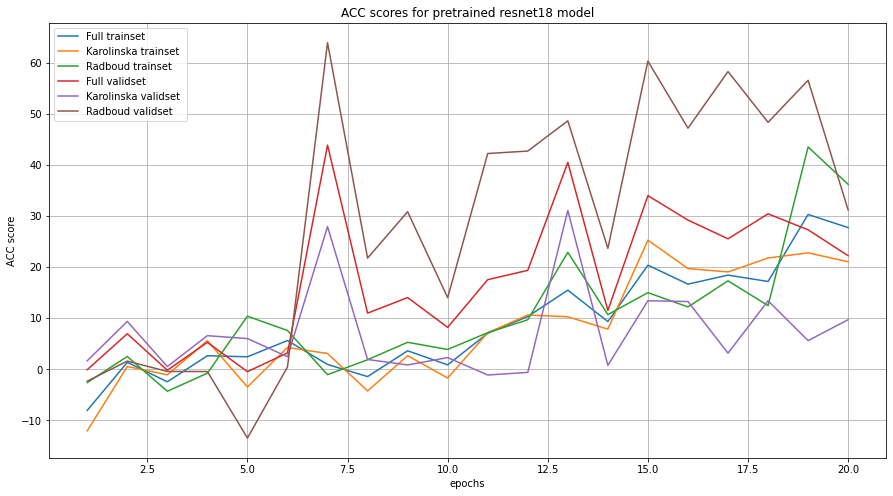

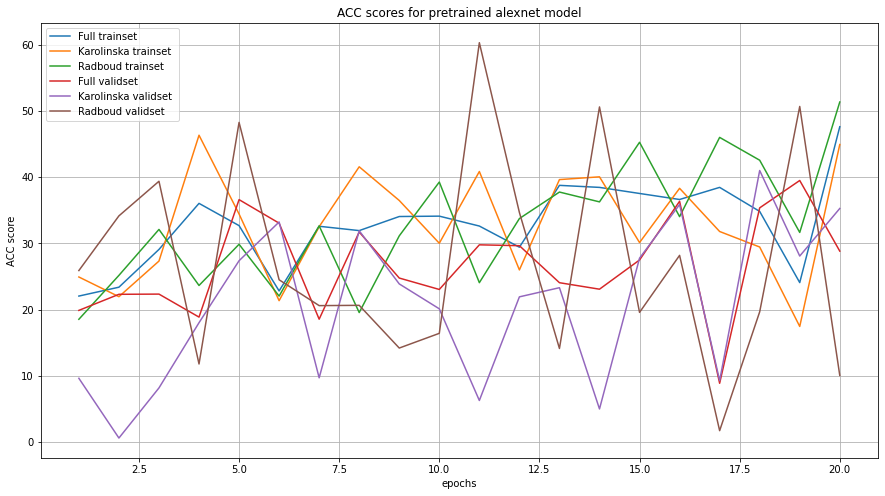

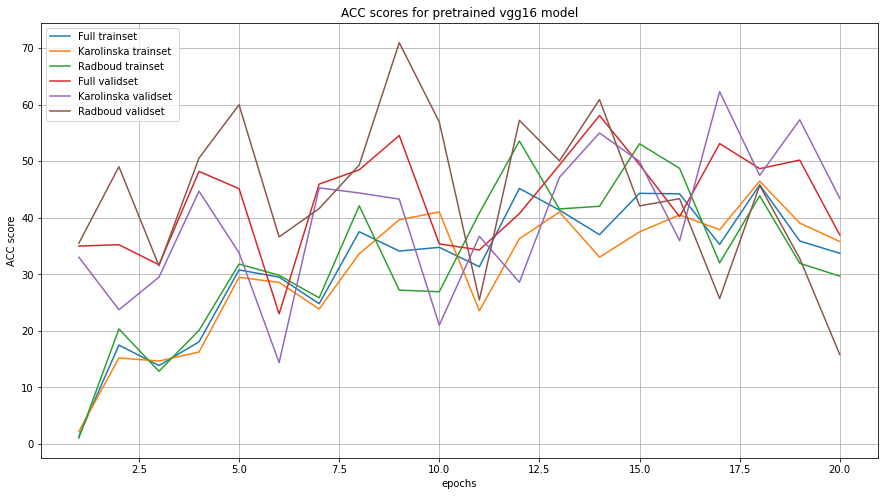

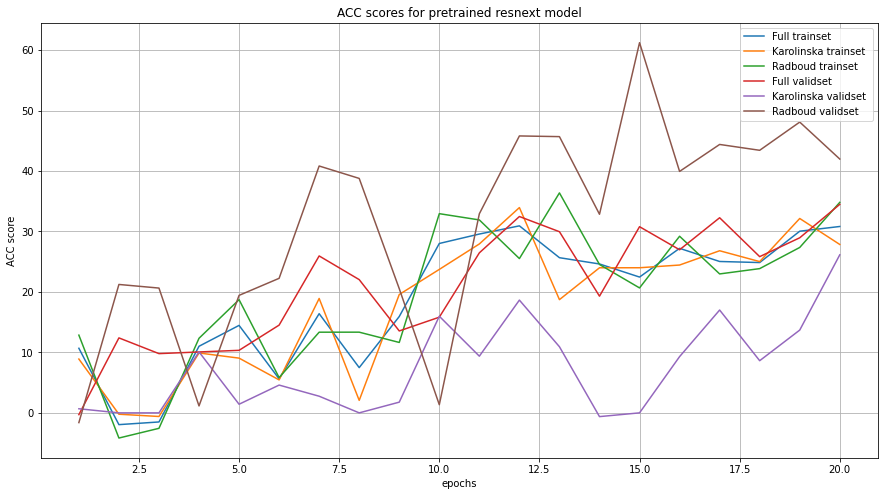

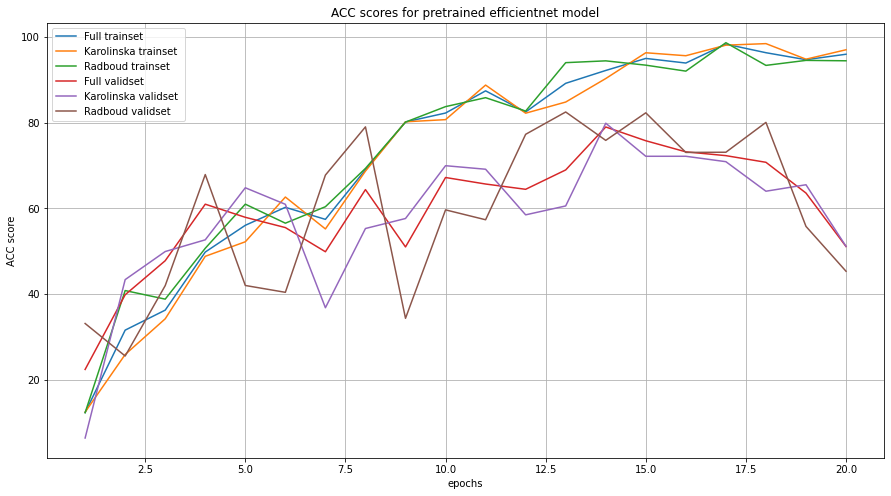

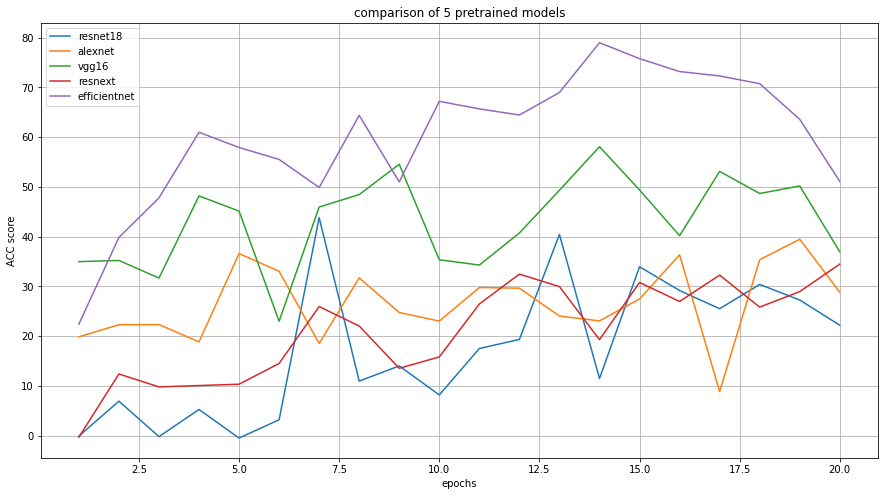

In [ ]:
comparison_list = []
for each in model_dict_pretrained.keys() :
    comparison_list.append(model_dict_pretrained[each][2])
    plot_accuracies_all(model_dict_pretrained[each][0],model_dict_pretrained[each][1],'pretrained '+each)
plot_accuracies_comparison(comparison_list, 'pretrained')

### Trained from scratch

In [30]:
startime = time.time()
model_dict_scratch = {}
for each in ['resnet18','alexnet','vgg16','resnext','efficientnet']:
    print("="*25+" "+each+" "+"="*25)
    model = create_model(each, pretrained=False)
    optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
    _ , acc_train_list, acc_valid_list, acc_list = train_model(model,optimizer,criterion,n_epochs)
    print(f'Execution time for trained from scratch {each} is {time.time()-startime} seconds')
    startime = time.time()
    model_dict_scratch[each]=[acc_train_list, acc_valid_list, acc_list]

========================= resnet18 =========================
score (0.000000 --> 43.402475).  Saving model ...
Epoch 1 -> Train Loss: 0.9159, Valid Loss: 1.0405, ACC_train: 17.19%, ACC_valid: 43.40%
score (43.402475 --> 62.591687).  Saving model ...
Epoch 2 -> Train Loss: 0.8640, Valid Loss: 0.8287, ACC_train: 27.56%, ACC_valid: 62.59%
Execution time for trained from scratch resnet18 is 78.88491225242615 seconds
========================= alexnet =========================
Epoch 1 -> Train Loss: 1.3791, Valid Loss: 0.8888, ACC_train: -3.96%, ACC_valid: 0.00%
Epoch 2 -> Train Loss: 0.8869, Valid Loss: 0.8836, ACC_train: -2.40%, ACC_valid: 0.00%
Execution time for trained from scratch alexnet is 38.634013175964355 seconds
========================= vgg16 =========================
Epoch 1 -> Train Loss: 1.8631, Valid Loss: 0.8862, ACC_train: -3.00%, ACC_valid: 0.00%
score (0.000000 --> 2.825736).  Saving model ...
Epoch 2 -> Train Loss: 0.8757, Valid Loss: 0.8502, ACC_train: 1.21%, ACC_valid

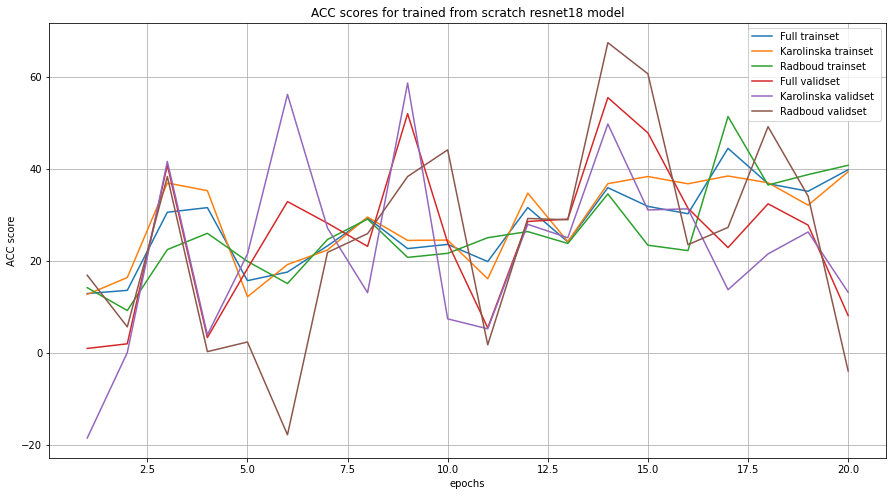

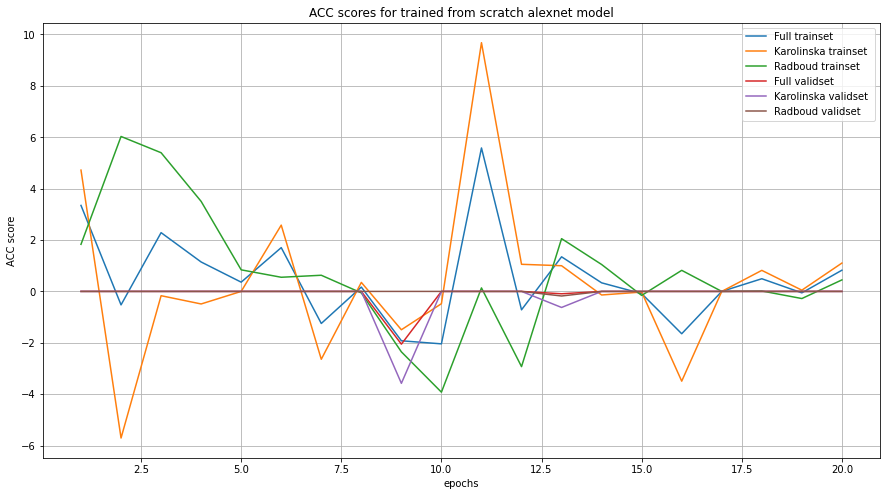

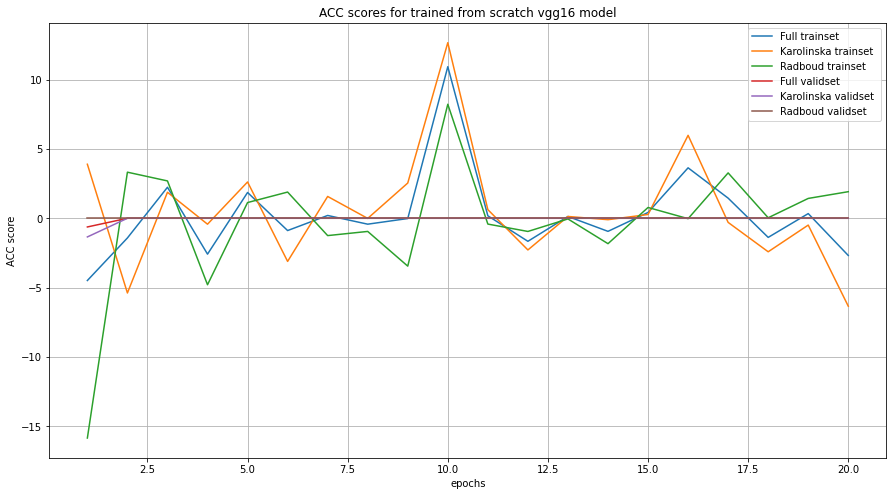

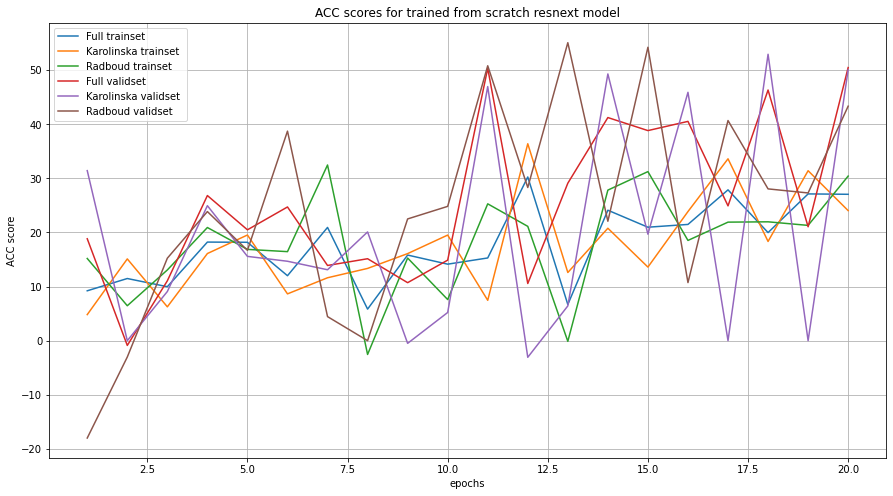

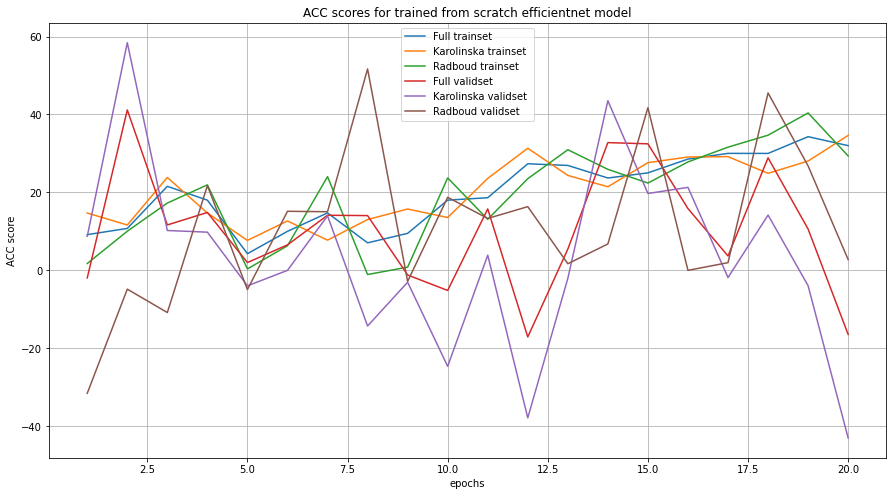

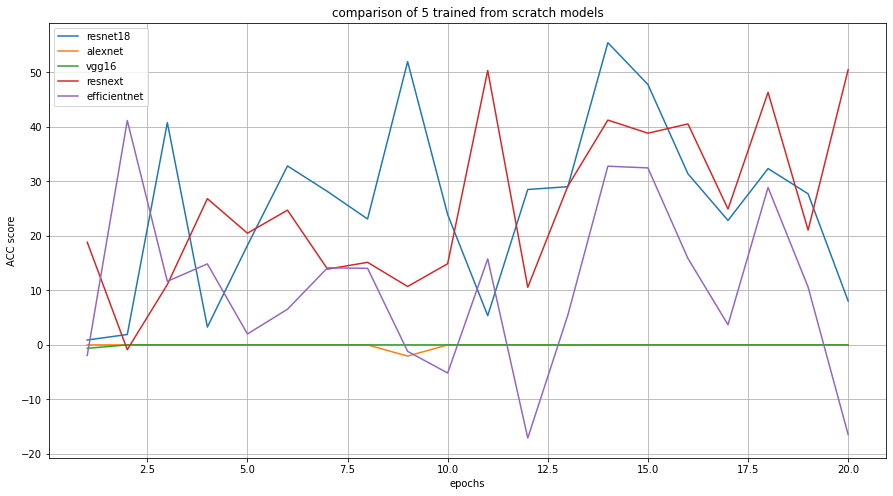

In [ ]:
comparison_list = []
for each in model_dict_scratch.keys() :
    comparison_list.append(model_dict_scratch[each][2])
    plot_accuracies_all(model_dict_scratch[each][0],model_dict_scratch[each][1],'trained from scratch '+each)
plot_accuracies_comparison(comparison_list, 'trained from scratch')

# 3) Final model : with masks

In [17]:
train, valid = train_test_split(train_df,test_size=0.2,stratify= train_df['isup_grade'])
batch_size = 1

train_dataset = Classifier_data(train.reset_index(drop=False),tiles_train)
valid_dataset = Classifier_data(valid.reset_index(drop=False),tiles_train)
train_loader = DataLoader(dataset=train_dataset, collate_fn = default_collate_masks, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, collate_fn = default_collate_masks, batch_size=batch_size, shuffle=False)

In [18]:
startime = time.time()
model_dict_pretrained = {}

model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, 6)
print(model._conv_stem)
model._conv_stem = efficientnet_pytorch.utils.Conv2dStaticSamePadding(4,32,3, image_size=256)
model = model.to(device)
model = torch.nn.DataParallel(model)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0
Conv2dStaticSamePadding(
  3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
  (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
)


In [19]:
startime = time.time()
optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
_ , acc_train_list, acc_valid_list, acc_list = train_model(model,optimizer,criterion,2)
print(f'Execution time is {time.time()-startime} seconds')
startime = time.time()
scores=[acc_train_list, acc_valid_list, acc_list]

Epoch 1 -> Train Loss: 1.7634, Valid Loss: 1.7025, ACC_train: 5.28%, ACC_valid: -6.34%
score (0.000000 --> 10.419808).  Saving model ...
Epoch 2 -> Train Loss: 1.6908, Valid Loss: 1.7123, ACC_train: 11.04%, ACC_valid: 10.42%
Execution time is 412.7546408176422 seconds


# 4) Final model : without masks

In [14]:
train, valid = train_test_split(train_df,test_size=0.1,stratify= train_df['isup_grade'])
batch_size = 2

train_dataset = Classifier_data(train.reset_index(drop=False),tiles_train)
valid_dataset = Classifier_data(valid.reset_index(drop=False),tiles_train)
train_loader = DataLoader(dataset=train_dataset, collate_fn = default_collate_ml, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, collate_fn = default_collate_ml, batch_size=batch_size,shuffle=False)

startime = time.time()
model_dict_pretrained = {}

model = create_model('efficientnet',pretrained=True)

startime = time.time()
optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
_ , acc_train_list, acc_valid_list, acc_list = train_model(model,optimizer,criterion,15)
print(f'Execution time is {time.time()-startime} seconds')
startime = time.time()
scores=[acc_train_list, acc_valid_list, acc_list]

score (0.000000 --> 12.928109).  Saving model ...
Epoch 1 -> Train Loss: 0.8405, Valid Loss: 0.9829, ACC_train: 14.44%, ACC_valid: 12.93%
score (12.928109 --> 63.215557).  Saving model ...
Epoch 2 -> Train Loss: 0.7886, Valid Loss: 0.7273, ACC_train: 35.68%, ACC_valid: 63.22%
score (63.215557 --> 77.582418).  Saving model ...
Epoch 3 -> Train Loss: 0.7397, Valid Loss: 0.6719, ACC_train: 49.50%, ACC_valid: 77.58%
Epoch 4 -> Train Loss: 0.6839, Valid Loss: 0.6265, ACC_train: 51.28%, ACC_valid: 76.20%
Epoch 5 -> Train Loss: 0.6433, Valid Loss: 0.5908, ACC_train: 62.01%, ACC_valid: 77.20%
Epoch 6 -> Train Loss: 0.5951, Valid Loss: 0.7754, ACC_train: 64.72%, ACC_valid: 69.73%
Epoch 7 -> Train Loss: 0.5367, Valid Loss: 0.8500, ACC_train: 74.37%, ACC_valid: 57.99%
Epoch 8 -> Train Loss: 0.4620, Valid Loss: 0.6868, ACC_train: 81.22%, ACC_valid: 76.41%
score (77.582418 --> 79.054564).  Saving model ...
Epoch 9 -> Train Loss: 0.4036, Valid Loss: 0.5753, ACC_train: 89.06%, ACC_valid: 79.05%
Epoch

# 5) Make submission

In [24]:
mask = True
if mask: 
    dataset_test = Classifier_data(anotation = test_df, tiles = tiles_test_masks, mode = 'test')
    test_loader = torch.utils.data.DataLoader(dataset=dataset_test, collate_fn = default_collate_masks_test, batch_size=batch_size, shuffle=False)
else :
    dataset_test = Classifier_data(anotation = test_df, tiles = tiles_test, mode = 'test')
    test_loader = torch.utils.data.DataLoader(dataset=dataset_test, collate_fn = default_collate_ml, batch_size=batch_size, shuffle=False)

In [25]:
preds = []
names = []
for i, (images, name) in enumerate(test_loader):
    images = images.cuda()

    with torch.no_grad():
        y_preds = model(images)
    pred = y_preds.cpu().numpy()
    preds.extend(pred)
    names.extend(name)

preds = [np.argmax(preds[i]) for i in range(len(preds))]    


In [26]:
result = pd.DataFrame({'Id': names,'Predicted':preds})
result.set_index('Id', inplace=True)
print(result)

                                  Predicted
Id                                         
254fbd7f21925ba7732800213af7ed47          3
8a76998072bccebf4c6f78ff7cc7b94e          3
7e81ad62302e6eabe1230d2d9d604881          3
3b343b8c4e2a854735a82bcebe482a14          3
1115d114a4339de8dd9f36d6465c6d57          5
...                                     ...
fa7ece1587e37e28416110063cc5266a          1
fda9a587d6bbfa5ceabe1840b2ae6337          3
7f1d716f6d571e3a9aece85c67774b33          3
0ab626bb7e1eb8c7b1eb6ac3fb129349          3
31a7aefb0e4723400ba7934ff463d663          3

[86 rows x 1 columns]


In [27]:
import csv
result.to_csv('submission_Final.csv',index_label='Id') 